[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/simple_detector_v2.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Подготовка ложноположительных детекций для обучения классификатора (класс background)

In [18]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

#import json
import os
#import numpy as np 
#import pandas as pd 
#import random
#import time

#import cv2
import torch
#import torch.utils.data
#from torch.utils.data import Dataset, DataLoader
import torchvision
#import torchvision.transforms as transforms
from torchvision.transforms import functional as func
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN

from PIL import Image
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline

#from pycocotools.coco import COCO
import fiftyone as fo

### Общие параметры

In [14]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
#elif torch.backends.mps.is_available() == True:
#    device = 'mps'
else:
    device = 'cpu'

#model_name = 'mobilenet_v3_320_b8'          # еще не обучена
#model_name = 'mobilenet_v3_b8'
#model_name = 'resnet50_b8'
#model_name = 'resnet50_v2_b8'
#model_name = 'resnet50_augmented_b8'
#model_name = 'resnet50_v2_augmented_b8'
model_name = 'resnet50_augmented_b16'
#model_name = 'resnet50_v2_augmented_b16'

epoch = 5      # эпоха для загрузки весов

### Загрузка детектора

In [16]:
def load_model_detection(model_name, num_classes, epoch):
    # load model
    if (model_name == 'resnet50_b8') or (model_name == 'resnet50_augmented_b8') or (model_name == 'resnet50_augmented_b16'):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
        print("Загружена модель resnet50")
    elif (model_name == 'resnet50_v2_b8') or (model_name == 'resnet50_v2_augmented_b8') or (model_name == 'resnet50_v2_augmented_b16'):
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
        print("Загружена модель resnet50_v2")
    elif model_name == 'mobilenet_v3_b8':
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=None)
        print("Загружена модель mobilenet_v3")
    elif model_name == 'mobilenet_v3_320_b8':    
        model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=None)
        print("Загружена модель mobilenet_v3_320")
    else:
        print("Неверно указано название модели")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_{epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Для модели {model_name} загружены веса эпохи {epoch}")
    model.eval()
    return model

model = load_model_detection(model_name, num_classes=2, epoch=epoch).to(device)

Загружена модель resnet50
Для модели resnet50_augmented_b16 загружены веса эпохи 5


### Загрузка валидационного датасета

In [5]:
#Load val dataset COCO

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
val_anno_file = "val_anno_bin_class.json"
val_anno_path = os.path.join(dataset_path, val_anno_file)

# Import the dataset
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=val_anno_path
)

 100% |███████████████| 5000/5000 [7.7s elapsed, 0s remaining, 697.3 samples/s]      


In [ ]:
#predictions_view = val_dataset.take(50, seed=42)

In [19]:
# Add and evaluating Faster-RCNN detections
# Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field

#classes = predictions_view.default_classes
classes = val_dataset.default_classes
# Add predictions
#for sample in predictions_view:
model.eval()
for i, sample in enumerate(val_dataset):
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        # Compute relative bounding box coordinates
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()
    if i % 100 == 0:
            print(f"\tОбработано {i} из {val_dataset.__len__()} сэмплов.")

	Обработано 0 из 5000 сэмплов.
	Обработано 100 из 5000 сэмплов.
	Обработано 200 из 5000 сэмплов.
	Обработано 300 из 5000 сэмплов.
	Обработано 400 из 5000 сэмплов.
	Обработано 500 из 5000 сэмплов.
	Обработано 600 из 5000 сэмплов.
	Обработано 700 из 5000 сэмплов.
	Обработано 800 из 5000 сэмплов.
	Обработано 900 из 5000 сэмплов.
	Обработано 1000 из 5000 сэмплов.
	Обработано 1100 из 5000 сэмплов.
	Обработано 1200 из 5000 сэмплов.
	Обработано 1300 из 5000 сэмплов.
	Обработано 1400 из 5000 сэмплов.
	Обработано 1500 из 5000 сэмплов.
	Обработано 1600 из 5000 сэмплов.
	Обработано 1700 из 5000 сэмплов.
	Обработано 1800 из 5000 сэмплов.
	Обработано 1900 из 5000 сэмплов.
	Обработано 2000 из 5000 сэмплов.
	Обработано 2100 из 5000 сэмплов.
	Обработано 2200 из 5000 сэмплов.
	Обработано 2300 из 5000 сэмплов.
	Обработано 2400 из 5000 сэмплов.
	Обработано 2500 из 5000 сэмплов.
	Обработано 2600 из 5000 сэмплов.
	Обработано 2700 из 5000 сэмплов.
	Обработано 2800 из 5000 сэмплов.
	Обработано 2900 из 5000 с

In [23]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = val_dataset.evaluate_detections(
    "faster_rcnn",
    gt_field="detections",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████| 5000/5000 [27.0s elapsed, 0s remaining, 228.3 samples/s]      
Performing IoU sweep...
 100% |███████████████| 5000/5000 [25.9s elapsed, 0s remaining, 255.5 samples/s]      



Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds




In [ ]:
fp_detections = val_dataset.filter_labels("faster_rcnn", fo.ViewField("eval") == "fp")

In [ ]:
from fiftyone import ViewField as F

In [ ]:
fp_detections = val_dataset.filter_labels("faster_rcnn", F("eval") == "fp",)


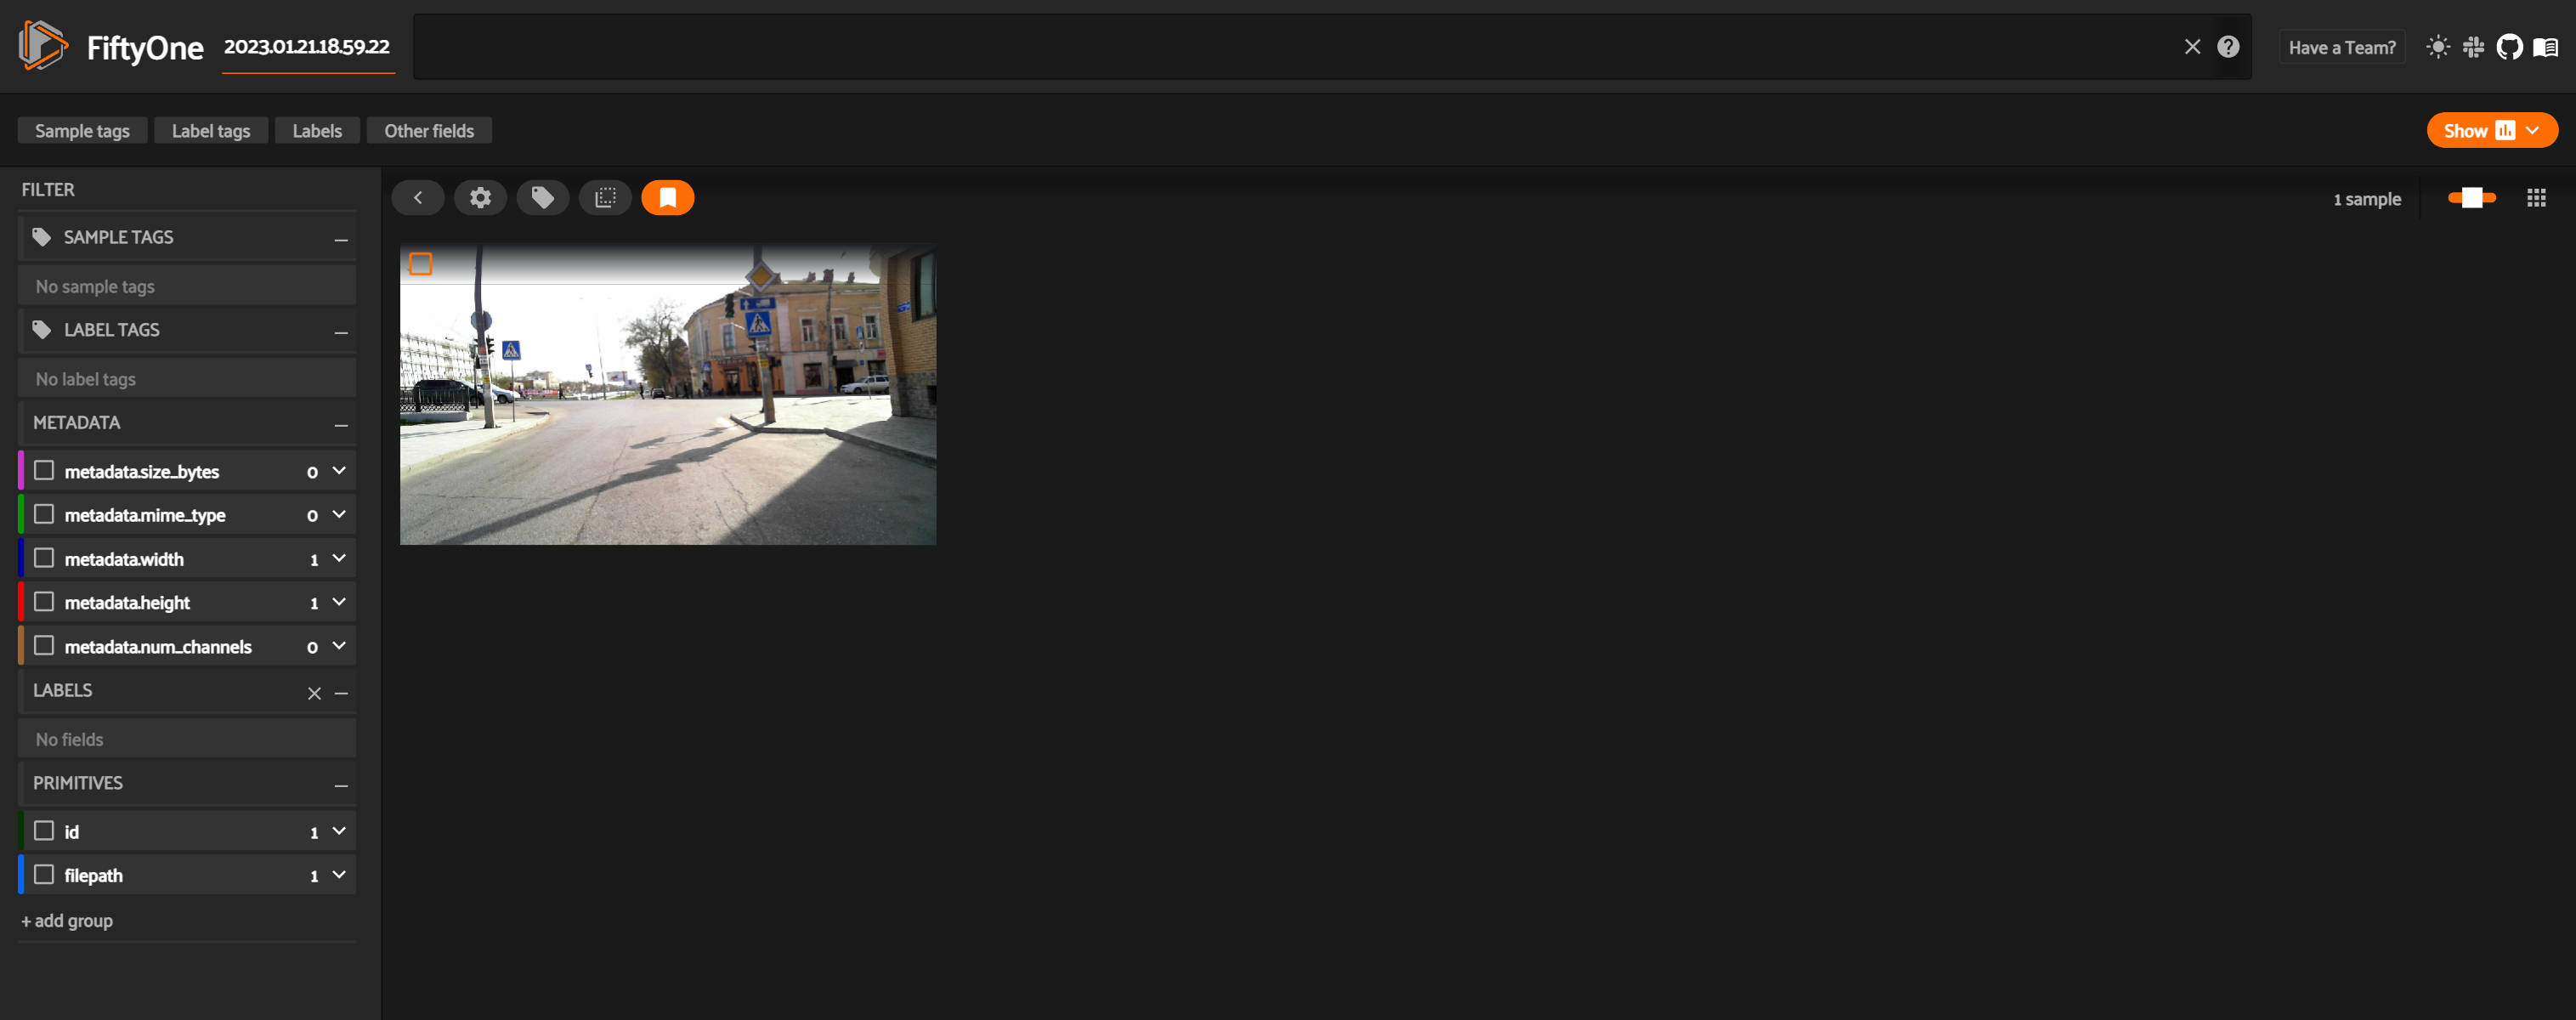

In [22]:
session = fo.launch_app(val_dataset)

In [21]:
session.close

<bound method Session.close of Dataset:          2023.01.21.21.44.05
Media type:       image
Num samples:      5000
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/>

In [7]:
session = fo.launch_app(fp_detections)

Evaluating detections...
 100% |███████████████████| 50/50 [215.1ms elapsed, 0s remaining, 232.5 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 50/50 [223.8ms elapsed, 0s remaining, 223.5 samples/s]      


In [10]:
fp_detections.export(
    export_dir='data/fp_detections',
    dataset_type=fo.types.COCODetectionDataset,
    label_field='faster_rcnn',
)

Directory 'data/fp_detections' already exists; export will be merged with existing files
 100% |███████████████████| 36/36 [115.3ms elapsed, 0s remaining, 312.1 samples/s]    


In [11]:
with open(os.path.join(dataset_path, 'fp_detections', 'labels.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
label_map

{'info': {'year': '',
  'version': '',
  'description': 'Exported from FiftyOne',
  'contributor': '',
  'url': 'https://voxel51.com/fiftyone',
  'date_created': '2023-01-15T22:25:44'},
 'licenses': [],
 'categories': [{'id': 0, 'name': 'sign', 'supercategory': None}],
 'images': [{'id': 1,
   'file_name': 'autosave10_10_2012_10_09_53_1.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 2,
   'file_name': 'autosave24_10_2012_11_53_17_0.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 3,
   'file_name': 'autosave09_10_2012_08_36_11_1.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 4,
   'file_name': 'autosave10_10_2012_10_32_01_0.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 5,
   'file_name': 'autosave23_10_2012_10_39_32_2.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'i

In [12]:
# загрузка датасета

# The directiry containing the source images
data_path = 'data/fp_detections/data'      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "labels.json"
labels_path = os.path.join(dataset_path, 'fp_detections', labels_file)


# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |███████████████████| 36/36 [93.5ms elapsed, 0s remaining, 384.9 samples/s]     



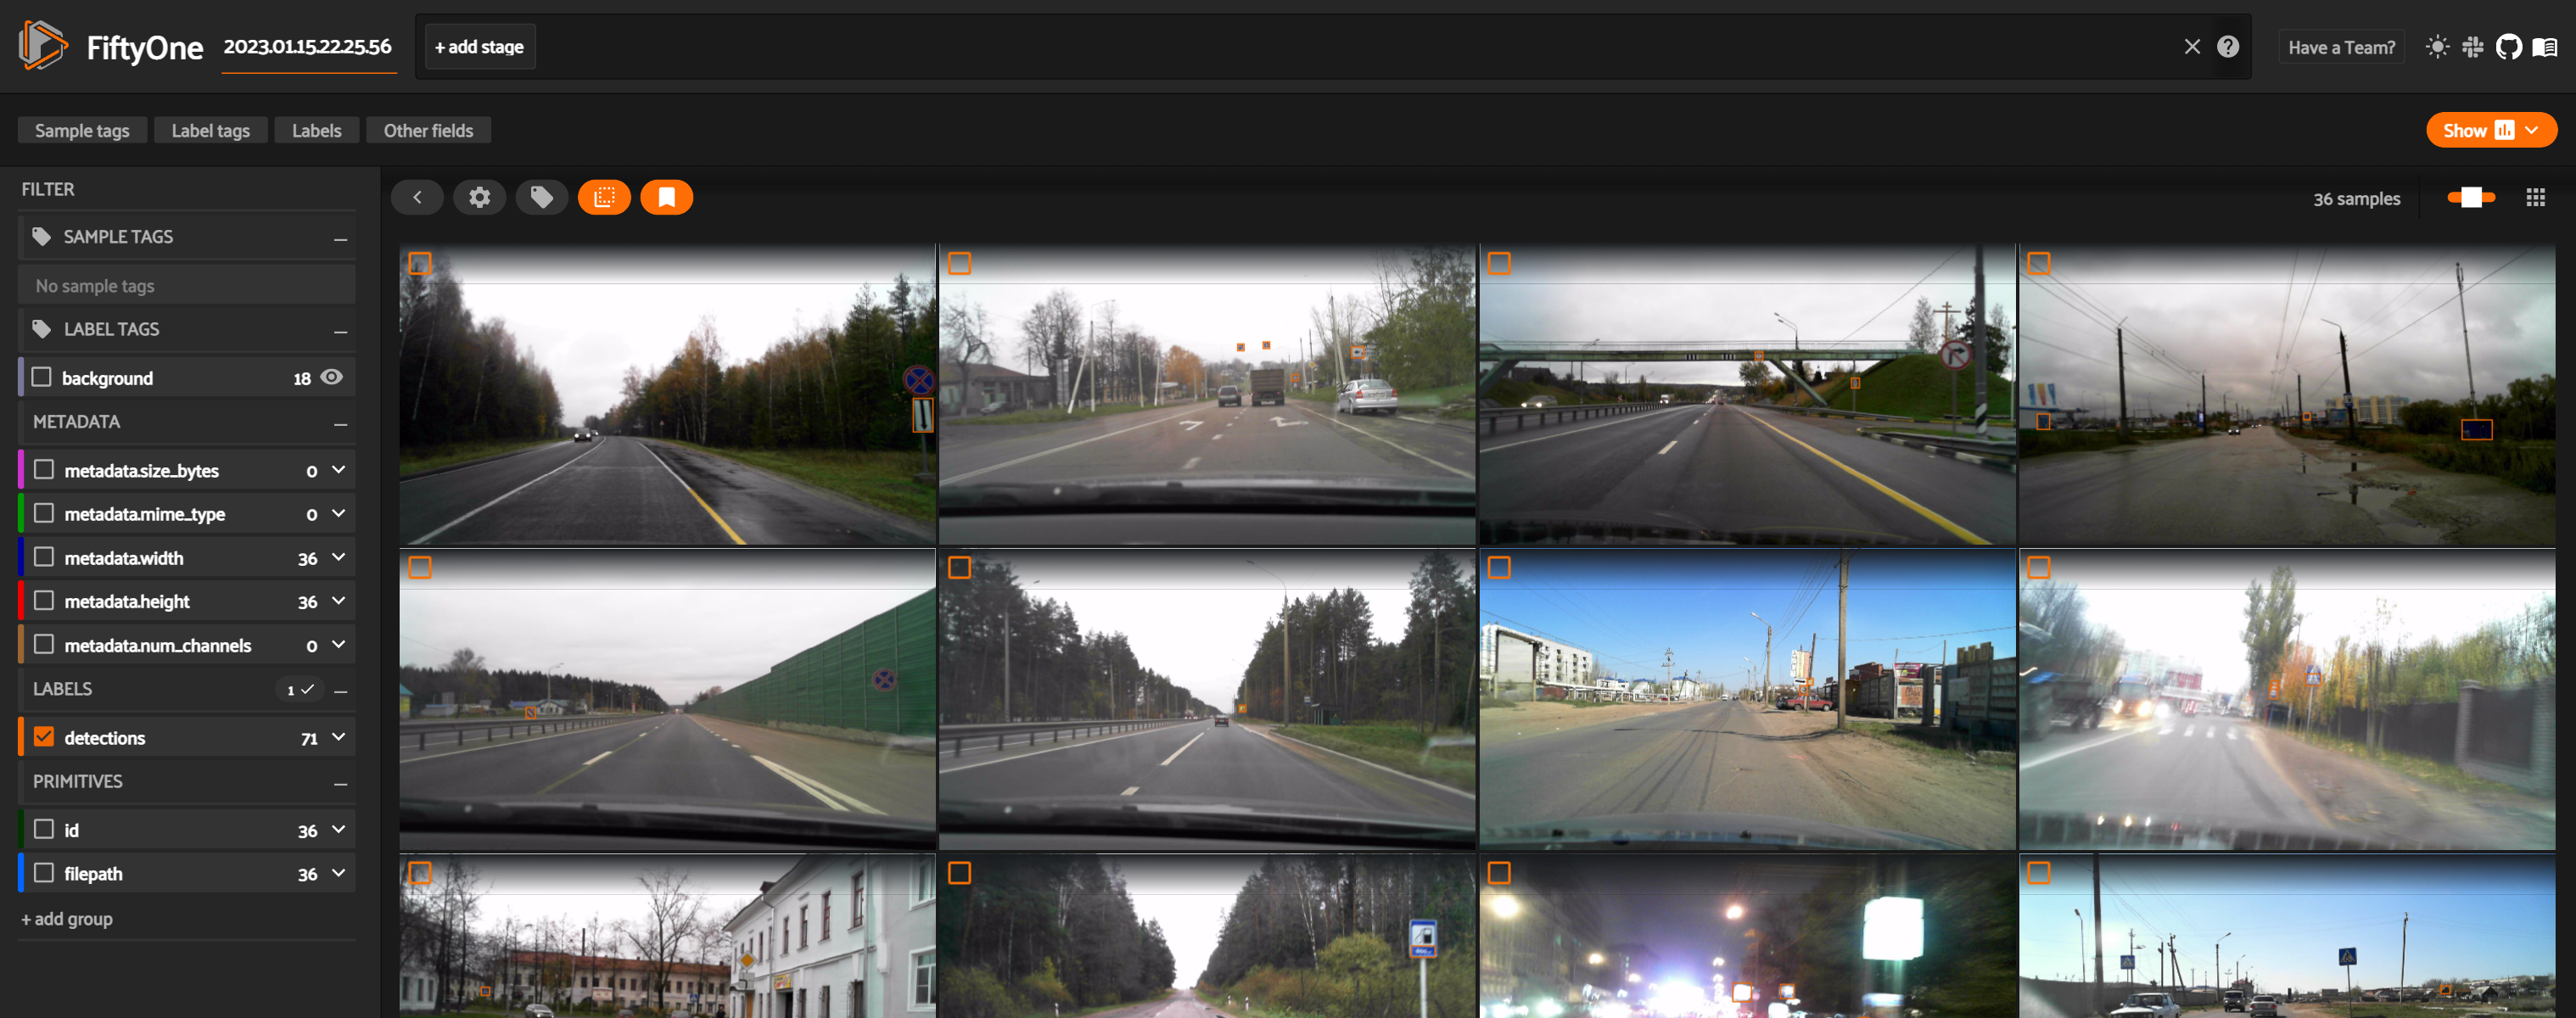

In [13]:
# Визуализация набора данных
session = fo.launch_app(dataset)

In [14]:
dataset.save

<bound method Dataset.save of Name:        2023.01.15.22.25.56
Media type:  image
Num samples: 36
Persistent:  False
Tags:        []
Sample fields:
    id:         fiftyone.core.fields.ObjectIdField
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)>

In [20]:
for sample in dataset:
    detections = []
    for i in range(len(sample.detections.detections)):
        if 'background' in sample.detections.detections[i]['tags']:
            label = sample.detections.detections[i]['label']
            box = sample.detections.detections[i]['bounding_box']
            score = sample.detections.detections[i]['confidence']
            detections.append(fo.Detection(label=label,
                                        bounding_box=box,
                                        confidence=score
                                        )
                            )
        sample['background'] = fo.Detections(detections=detections)
        sample.save()

In [ ]:
for sample in predictions_view:
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        # Compute relative bounding box coordinates
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()

In [21]:
dataset_background = dataset.filter_labels('background', F("label") == "sign")
dataset_background.export(
    export_dir='data/dataset_background',
    dataset_type=fo.types.COCODetectionDataset,
    label_field='background',
)

Directory 'data/dataset_background' already exists; export will be merged with existing files
 100% |███████████████████| 12/12 [39.2ms elapsed, 0s remaining, 306.5 samples/s] 


In [22]:
with open(os.path.join(dataset_path, 'dataset_background', 'labels.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()
label_map

{'info': {'year': '',
  'version': '',
  'description': '',
  'contributor': '',
  'url': 'https://voxel51.com/fiftyone',
  'date_created': '2023-01-15T22:25:44'},
 'licenses': [],
 'categories': [{'id': 0, 'name': 'sign', 'supercategory': None}],
 'images': [{'id': 1,
   'file_name': 'autosave24_10_2012_11_53_17_0.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 2,
   'file_name': 'autosave10_10_2012_10_32_01_0.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 3,
   'file_name': 'autosave16_04_2013_14_47_55_0.jpg',
   'height': 1080,
   'width': 1920,
   'license': None,
   'coco_url': None},
  {'id': 4,
   'file_name': 'autosave16_10_2012_06_48_40_0.jpg',
   'height': 720,
   'width': 1280,
   'license': None,
   'coco_url': None},
  {'id': 5,
   'file_name': 'autosave16_04_2013_14_45_17_4.jpg',
   'height': 1080,
   'width': 1920,
   'license': None,
   'coco_url': None},
  {'id': 6,
   'file_name

In [23]:
# загрузка датасета

# The directiry containing the source images
data_path = 'data/dataset_background/data'      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "labels.json"
labels_path = os.path.join(dataset_path, 'dataset_background', labels_file)


# Import the dataset
dataset_background = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |███████████████████| 12/12 [35.9ms elapsed, 0s remaining, 334.0 samples/s]     


In [24]:
# Визуализация набора данных
session = fo.launch_app(dataset_background)